<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-Bethe-lattice-subgraph" data-toc-modified-id="Create-a-Bethe-lattice-subgraph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a Bethe lattice subgraph</a></span><ul class="toc-item"><li><span><a href="#circuit-line-graph" data-toc-modified-id="circuit-line-graph-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>circuit line graph</a></span></li></ul></li><li><span><a href="#Get-contraction-cost-estimations" data-toc-modified-id="Get-contraction-cost-estimations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get contraction cost estimations</a></span></li><li><span><a href="#Bethe-lattice-subgraphs-complexity-estimation" data-toc-modified-id="Bethe-lattice-subgraphs-complexity-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bethe lattice subgraphs complexity estimation</a></span></li></ul></div>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import qtensor as qt
from cartesian_explorer import Explorer, parallels, caches
import cartesian_explorer.caches as caches


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
parallel = parallels.Ray()
cache = caches.JobLibCache('../../../data/a/cache/skylake_tree/')
ex = Explorer(parallel=parallel, cache=cache)

In [3]:
#ex=Explorer()

## Create a Bethe lattice subgraph

In [26]:
@ex.provider
def bethe_graph(p, degree):
    return qt.toolbox.bethe_graph(p, degree)

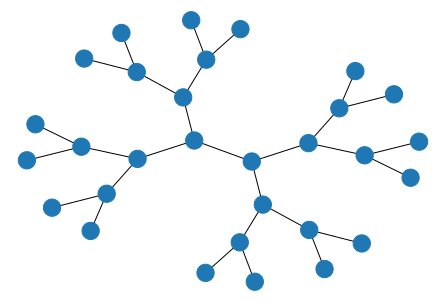

In [117]:
fig = plt.figure(figsize=(6,4))
G = bethe_graph(p=3, degree=3)
nx.draw_kamada_kawai(G)
#plt.title('Bethe lattice subgraph for p=3')
plt.savefig('../../../data/figures/best_gb_paper/bethe_p3.pdf')

In [31]:
sum(2**(x+1) for x in range(5))

62

In [7]:
@ex.provider
def bethe_lightcone_circuit(bethe_graph, beta, gamma, composer_type='cone'):
    if composer_type=='cone':
        Composer = qt.QtreeQAOAComposer
    elif composer_type=='cylinder':
        Composer = qt.OldQtreeQAOAComposer
    elif composer_type=='zz':
        Composer = qt.ZZQtreeQAOAComposer
    elif composer_type=='zz_simp':
        Composer = qt.SimpZZQtreeComposer
    else:
        raise Exception(f'Composer {composer_type} is not supported')
    
    print('beta, gamma', beta, gamma, 'type', composer_type)
    comp = Composer(bethe_graph, gamma=gamma, beta=beta)
    comp.energy_expectation_lightcone((0, 1))
    print('len', len(comp.circuit))
    return tuple(comp.circuit)
    

In [41]:
p = 3
circ1 = bethe_lightcone_circuit(G, (0.1,)*p, (0.2,)*p, composer_type='zz')
circ2 = bethe_lightcone_circuit(G, (0.1,)*p, (0.2,)*p, composer_type='zz_simp')
print('Number of gates in circ: ', len(circ1), 'vs', len(circ2))

Number of gates in circ:  200 vs 200


### circuit line graph

In [42]:
tn = qt.optimisation.QtreeTensorNet.from_qtree_gates(circ1)
lg = tn.get_line_graph()

In [43]:
ex.use_svg()
ex.set_size(8,6)

In [60]:
import qtree

In [62]:
lg2 = qtree.graph_model.peo_calculation.get_simple_graph(lg)
qt.utils.eliminate_low_degrees(lg2)

62

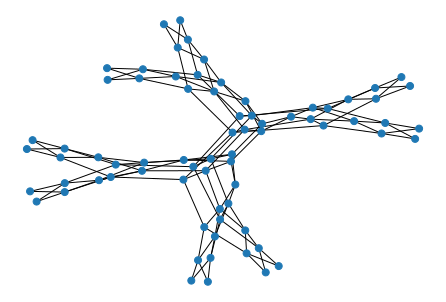

In [113]:
fig = plt.figure(figsize=(6,4))
nx.draw_spring(lg2, node_size=50, )
plt.savefig('../../../data/figures/best_gb_paper/line_graph_p3.pdf')

## Get contraction cost estimations

In [9]:
@ex.provider
def circuit_sim_tw(bethe_lightcone_circuit, ordering_algo='default'):
    circuit = bethe_lightcone_circuit
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    opt = qt.toolbox.get_ordering_algo(ordering_algo)
    try:
        peo, _ = opt.optimize(tn)
    except Exception as e:
        print("error", e)
        return None
    return opt.treewidth
    
@ex.provider
def circuit_sim_costs(bethe_lightcone_circuit, ordering_algo='default'):
    circuit = bethe_lightcone_circuit
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    opt = qt.toolbox.get_ordering_algo(ordering_algo)
    peo, _ = opt.optimize(tn)
    costs, mems = tn.simulation_cost(peo)
    print('tn', tn.get_line_graph().number_of_nodes())
    return tuple(costs), tuple(mems)

@ex.provider
def max_memory(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return max(mems)

@ex.provider
def sum_flops(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return sum(costs)

beta, gamma (0.3, 0.3, 0.3) (0.2, 0.2, 0.2) type cone
len 388
tn 322


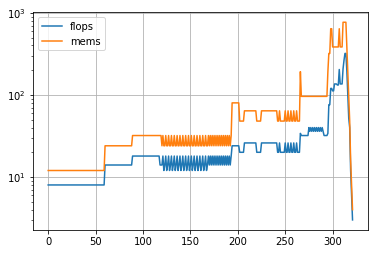

In [10]:
p = 3
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.3, )*p,
                    degree=3
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

beta, gamma (0.3, 0.3, 0.3) (0.2, 0.2, 0.2) type cone
len 388
tn 322


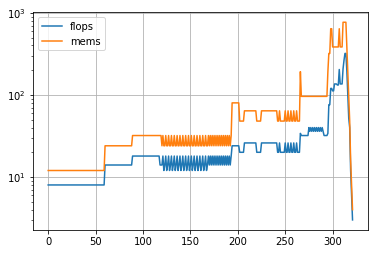

In [11]:
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.3, )*p,
                              degree=3, composer_type='cone'
                             )
plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

In [11]:
@ex.provider
def expectation_value(bethe_lightcone_circuit):
    circuit = bethe_lightcone_circuit
    sim = qt.QtreeSimulator()
    E = sim.simulate(circuit)
    return E[0]

In [12]:
gamma = np.array([-1.358922, 0.40041, -1.101348])
beta = np.array([-0.6072757, -0.45687, 0.2329651])
gamma *= -1/np.pi
beta *= 1/np.pi
E = ex.get_variable('expectation_value', p=3, degree=3,
                    gamma=tuple(gamma), beta=tuple(beta))
print('Expectation', E)

Expectation (-0.584775547118884-6.453171330633722e-16j)


In [13]:
@ex.add_function(provides=('beta', 'gamma'), requires='p')
def get_dummy_beta_gamma(p):
    beta = [.1]*p
    gamma = [.2]*p
    return tuple(beta), tuple(gamma)

## Bethe lattice subgraphs complexity estimation

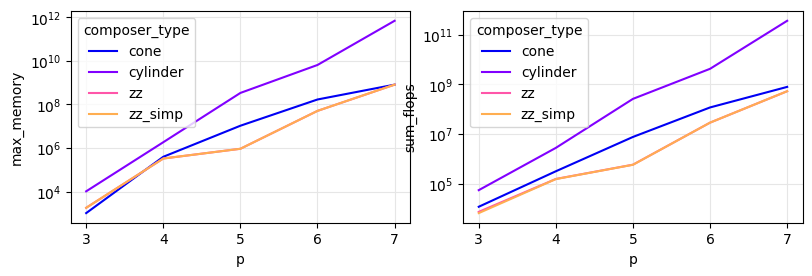

In [19]:
ps = [3, 4, 5, 6, 7]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3],
                    composer_type = ['cone', 'cylinder', 'zz', 'zz_simp'],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.yscale('log')

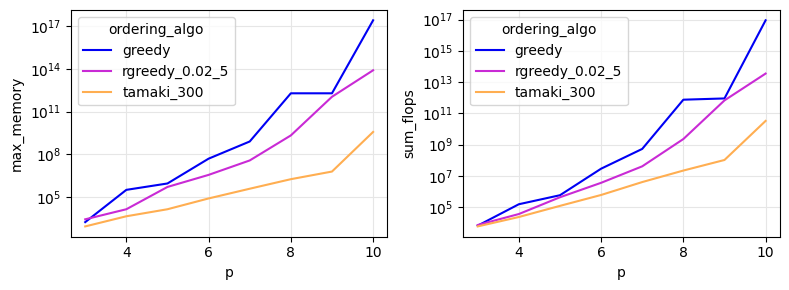

In [35]:
ps = [3, 4, 5, 6, 7, 8, 9, 10]
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, '*', **kwargs)
    plt.yscale('log')
    
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    plot_func=custom_plot,
                    degree = [3],
                    ordering_algo=['greedy', 'rgreedy_0.02_5', 'tamaki_300'],
                    composer_type = ['zz_simp'],
                    p=ps,
                   )


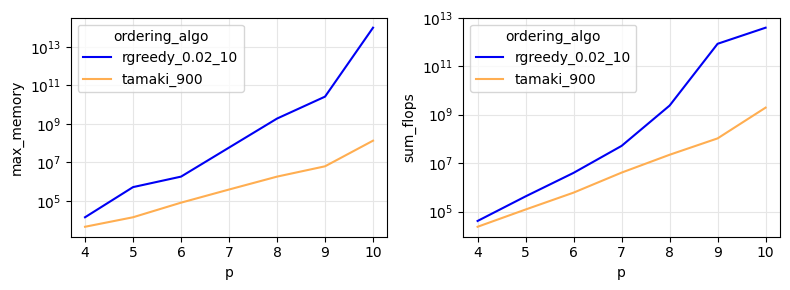

In [36]:
ps = [4, 5, 6, 7, 8, 9, 10]
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, '*', **kwargs)
    plt.yscale('log')
    
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    plot_func=custom_plot,
                    degree = [3],
                    ordering_algo=['rgreedy_0.02_10', f'tamaki_{15*60}'],
                    composer_type = ['zz_simp'],
                    p=ps,
                   )


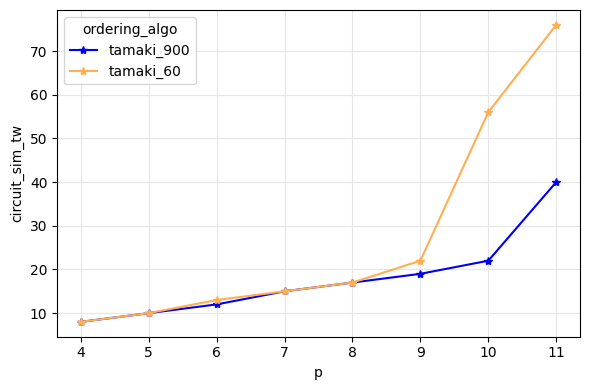

In [16]:
ps = [4, 5, 6, 7, 8, 9, 10, 11, 12]
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, '*-', **kwargs)
    #plt.yscale('log')
    
f = ex.plot_variables2d('circuit_sim_tw',
                    plot_func=custom_plot,
                    degree = [3],
                    ordering_algo=[f'tamaki_{15*60}', f'tamaki_{60}'],
                    composer_type = ['zz_simp'],
                    p=ps,
                   )


beta, gamma (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2) type old
my type is OldQtreeQAOAComposer
len 67406


KeyboardInterrupt: 

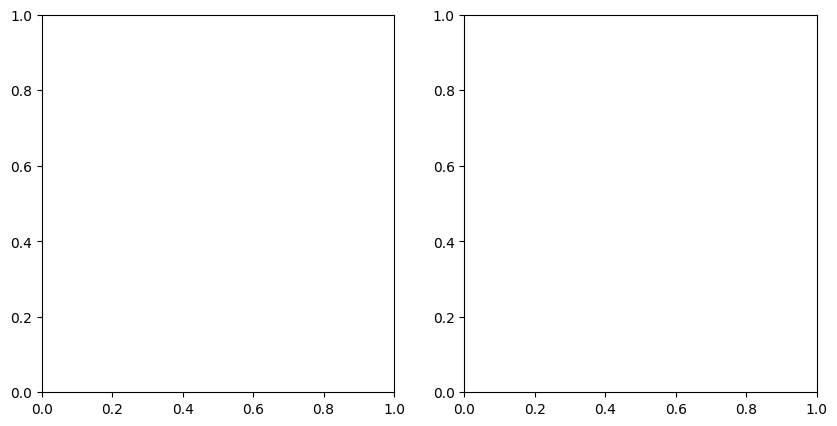

In [17]:
p = 8
f, axs = plt.subplots(1,2,figsize=(10, 5), dpi=100)
plt.sca(axs[0])
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='old'
                   )


plt.sca(axs[0])
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

for ax in axs:
    plt.sca(ax)
    plt.plot(flops, label='flops')
    plt.plot(mems, label='mems')
    plt.legend()
    plt.yscale('log')
    plt.grid()

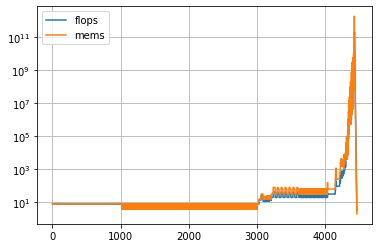

In [132]:
p = 8
flops, mems = ex.get_variable('circuit_sim_costs', p=p, gamma=(0.2, )*p, beta=(0.1, )*p,
                    degree=3, composer_type='new'
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

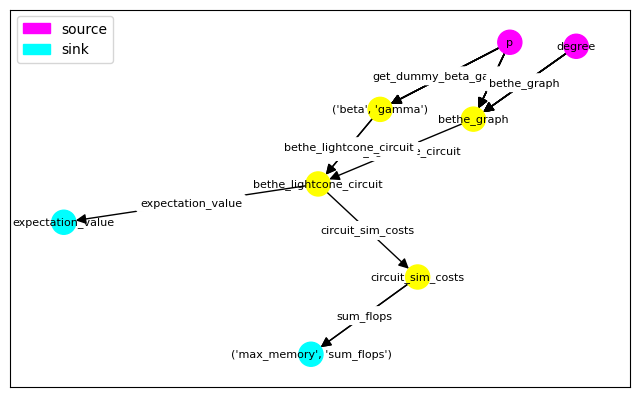

In [125]:
_ = ex.draw_dependency_graph()